In [2]:
import tomotopy as tp
import numpy as np
import pandas as pd
import re
import os
import time
import itertools
import konlpy
from kiwipiepy import Kiwi
from hanspell import spell_checker
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyLDAvis


In [3]:
df=pd.read_csv('leisure2.csv',encoding='utf-8-sig',header=0, dtype={'score':np.str})
df.info()

C:\Users\jenny\AppData\Local\Temp/ipykernel_25316/1705503032.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df=pd.read_csv('leisure2.csv',encoding='utf-8-sig',header=0, dtype={'score':np.str})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12029 entries, 0 to 12028
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    12029 non-null  int64 
 1   real_date     12029 non-null  object
 2   year          12029 non-null  int64 
 3   month         12029 non-null  int64 
 4   type          10567 non-null  object
 5   review_title  12029 non-null  object
 6   review        12029 non-null  object
 7   score         12029 non-null  object
 8   dataset       11869 non-null  object
dtypes: int64(3), object(6)
memory usage: 845.9+ KB


In [4]:
df[df['dataset'].isnull()]

,Unnamed: 0,real_date,year,month,type,review_title,review,score,dataset
140,140,2015년 4월,2015,4,친구,경복궁 을 4월 2015,"전반적으로, 이 잘 유지되는 거리. 당신이 주변의 길 이 쉽게, 심지어는 표지판이 ...",4,NaN
146,146,2015년 4월,2015,4,가족,다른 관광지를 방문하는 데 pecfectly; 경복궁과 창덕궁,나와 내 가족은 매우 즐거운 방문입니다. 제가 한국에서 몇 년 전에 강한 느낌을 받...,5,NaN
523,523,2015년 9월,2015,9,개인,많은 메모리가 아닌 넓은 남아 있는,제가 처음에 이: 광화문. 이 그림같은 풍경을 사진도 가능합니다 도 두 섬을 가장 ...,4,NaN
527,527,2015년 9월,2015,9,가족,아름다운 궁전,부모님과 저는 한 달이 지난 수요일에 팰리스 입장료는 제도가! 우리는 전통적인 음악...,4,NaN
619,619,2015년 10월,2015,10,커플,아름다운 고대 궁전,"저희가 마지막 달의 하루는 수요일 지정된 배양물, 입구에 팰리스가 무료였습니다. 가...",5,NaN
...,...,...,...,...,...,...,...,...,...
11615,11616,2016년 7월,2016,7,친구,한국에 좋은 역사적인 소개,나는 친구와 함께 하는 시크릿 가든 투어 (1.5 시간 투어) 의 관점이 되는 만족...,4,NaN
11714,11715,2016년 10월,2016,10,커플,멋진 도시에 와,"저는, 서울을 방문하는 많은 복잡함. 궁전의 정원이 되었지만 여전히 바빴지만 및 방...",4,NaN
11756,11757,2016년 11월,2016,11,개인,잊을 수 없는 유네스코 문화 유산!,근처에 살고 있고. 저는 말 그대로 침대에 영어 가이드 투어를 잡기 위해 10:30...,5,NaN
11918,11919,2017년 6월,2017,6,커플,아름다운 정원,"저희 창덕궁 으로 시간이 10:30 인데 영어 투어, 투어 를 찾는 실제로 시작 1...",5,NaN


In [5]:
#결측치 데이터 지우기
df.dropna(subset=['dataset'], how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11869 entries, 0 to 12028
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    11869 non-null  int64 
 1   real_date     11869 non-null  object
 2   year          11869 non-null  int64 
 3   month         11869 non-null  int64 
 4   type          10416 non-null  object
 5   review_title  11869 non-null  object
 6   review        11869 non-null  object
 7   score         11869 non-null  object
 8   dataset       11869 non-null  object
dtypes: int64(3), object(6)
memory usage: 927.3+ KB


In [6]:
#응집도 계산 전 사용할 토크나이저 함수 정의
kiwi = Kiwi()


stop_list=['우리','함께','모든','리스']
def co_tokenize(sent):
    res, score = kiwi.analyze(sent)[0] # 첫번째 결과를 사용
    
    return [word + ('다' if tag.startswith('V') else '')
# 동사에는 '다'를 붙여줌
            for word, tag, a, length in res
            if not tag.startswith('E') and not tag.startswith('J') and not tag.startswith('S') and not tag.startswith('MA') 
            and length > 1 and word not in stop_list]
import konlpy

def tokenize_korean_text(text):
    text = re.sub(r'[^,.?!\w\s]','', text)
    
    okt = konlpy.tag.Okt()
    Okt_morphs = okt.pos(text)
    
    words = []
    for word, pos in Okt_morphs:
        if not pos == 'Josa' and len(word) > 1 :
            words.append(word)
    ## word를 이어붙인 string 형태가 아닌 word의 list를 return해주는 게 sklearn lda 준비 과정과의 차이
            
    return words

In [7]:
tokenized_list2 = []
a=df['dataset'].values
for text in range(len(a)):
    tokenized_list2.append(tokenize_korean_text(a[text]))

In [16]:
len(tokenized_list2)

11869

In [50]:
mdl= tp.LDAModel(alpha=0.1,eta=0.01, k=20, min_cf=9, rm_top=3,tw=tp.TermWeight.IDF)

for line in range(len(tokenized_list2)):
    try :
        mdl.add_doc(tokenized_list2[line])
    except :
        pass

In [51]:
mdl.train(0)
print('Num docs:{}, Num Vocabs:{}, Total Words:{}'.format(len(mdl.docs), len(mdl.used_vocabs), mdl.num_words))
print('Removed Top words: ', *mdl.removed_top_words)

# Let's train the model
for i in range(0, 1000, 20):
    mdl.train(20)
mdl.summary()

Num docs:11869, Num Vocabs:3474, Total Words:299354
Removed Top words:  있는 좋은 서울
<Basic Info>
| LDAModel (current version: 0.12.2)
| 11869 docs, 299354 words
| Total Vocabs: 20570, Used Vocabs: 3474
| Entropy of words: 6.95554
| Entropy of term-weighted words: 7.48549
| Removed Vocabs: 있는 좋은 서울
|
<Training Info>
| Iterations: 1000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.15930
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 9 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 808269785 (random seed)
| trained in version 0.12.2
|
<Para

==== Coherence : c ====
Average: 0.7364549527317286 
Per Topic: [0.7077717930078506, 0.6098094850778579, 0.5725939854979515, 0.792835122346878, 0.7402521371841431, 0.8368537902832032, 0.7058905392885209, 0.785819286108017, 0.8331261873245239, 0.783738088607788, 0.7812964439392089, 0.7069524019956589, 0.7428617596626281, 0.7103191077709198, 0.842006367444992, 0.6876957058906555, 0.6868976712226867, 0.6862179934978485, 0.7856866240501403, 0.7304745644330979]


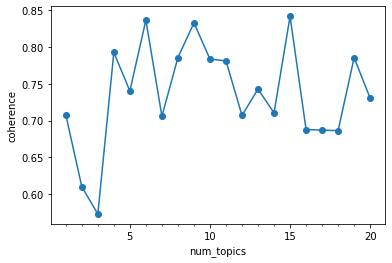

In [52]:
# calculate coherence using preset
ax=plt.axes()
coh = tp.coherence.Coherence(mdl, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdl.k)]
print('==== Coherence : c ====')
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
x=range(1,21,1)
plt.plot(x, coherence_per_topic,marker='o')
plt.xlabel("num_topics")
plt.ylabel("coherence")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()
print()

위 결과에서 14개일 때 가장 높은 응집도를 보였기 때문에 토픽을 14개로 설정하였다.

In [53]:
model = tp.DMRModel(k=6, alpha=0.1, eta=0.01, min_cf=9,rm_top=3,tw=tp.TermWeight.IDF)
# tw에 tp.TermWeight의 항목 중 하나를 선택하여 입력할 수 있습니다.
# 기본값은 tp.TermWeight.ONE이며, 이는 모든 단어를 동등하게 보겠다는 것입니다.
# 다른 선택지로는 tp.TermWeight.IDF나 tp.TermWeight.PMI가 있습니다.

In [54]:
key=df['score'].values
value=tokenized_list2
stop_list=['우리','함께','모든','리스']

# tokenize 함수를 정의합니다. 한국어 문장을 입력하면 형태소 단위로 분리하고, 
# 불용어 및 특수 문자 등을 제거한 뒤, list로 반환합니다.
def tokenize(sent):
    res, score = kiwi.analyze(sent)[0] # 첫번째 결과를 사용
    
    return [word + ('다' if tag.startswith('V') else '')
# 동사에는 '다'를 붙여줌
            for word, tag, a, length in res
            if not tag.startswith('E') and not tag.startswith('J') and not tag.startswith('S') and not tag.startswith('MA')
            and length > 1 and word not in stop_list] # 조사, 어미, 특수기호는 제거


for pairs in zip(key,value):
    try :
        model.add_doc(pairs[1],metadata=pairs[0]) # tokenize함수를 이용해 전처리한 결과를 add_doc에 넣습니다.
    except RuntimeError :
        pass
        
               
model.train(0)
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 
 
 
for i in range(200):
    model.train(1)
    
for i in range(model.k):
    res = model.get_topic_words(i, top_n=10)
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))

Total docs: 11869
Total words: 299354
Vocab size: 3474
Topic #0	경복궁, 야간, 한복, 개장, 외국인, 한국, 창덕궁, 궁궐, 후원, 모습
Topic #1	한강, 공원, 자전거, 산책, 좋아요, 청계천, 도심, 하기, 좋고, 입니다
Topic #2	궁전, 투어, 팰리스, 가이드, 역사, 정원, 가든, 한국, 방문, 시크릿
Topic #3	야경, 남산, 케이블카, 너무, 코스, 남산타워, 북한, 좋아요, .., 구경
Topic #4	타워, 전망, 케이블카, 타고, 도시, 멋진, 있습니다, 우리, 버스, 사랑
Topic #5	건물, 아름다운, 많은, 우리, 있습니다, 방문, 지역, 하는, 쇼핑, 도시


In [55]:
model.summary()

<Basic Info>
| DMRModel (current version: 0.12.2)
| 11869 docs, 299354 words
| Total Vocabs: 20570, Used Vocabs: 3474
| Entropy of words: 6.95554
| Entropy of term-weighted words: 7.48549
| Removed Vocabs: 있는 좋은 서울
| Metadata of docs and its distribution
|  5: 5961
|  3: 1301
|  4: 4422
|  2: 141
|  1: 44
|
<Training Info>
| Iterations: 200, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.35051
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 9 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 6 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (an initial value of exponential of mean of normal distribution for `lambdas`, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic - word)
| sigma: 1.0 (standard deviation of nor

In [56]:
#감성점수 계산
print('Topic distributions by score')

df2=pd.DataFrame()
score_labels=['1','2','3','4','5']
for i in score_labels:
    df2[i+'score']=model.get_topic_prior(i)
df2['total']=df2.sum(axis=1)

total_sum=df2['total'].values
gamsung_sum=0
gamsung_list=[]
for i in range(model.k):
    a=df2.iloc[i,:-1].values
    gamsung_sum=(a[0]*1+a[1]*2+a[2]*3+a[3]*4+a[4]*5)/total_sum[i]
    gamsung_list.append(gamsung_sum)
    
df2['re_score']=gamsung_list
df2=df2.round(3)
df2.head(20)

Topic distributions by score


,1score,2score,3score,4score,5score,total,re_score
0,0.130,0.060,0.010,0.015,0.034,0.249,2.052
1,0.113,0.061,0.037,0.035,0.038,0.284,2.378
2,0.019,0.076,0.038,0.031,0.042,0.205,3.010
3,0.036,0.164,0.063,0.022,0.009,0.293,2.337
4,0.042,0.028,0.084,0.042,0.055,0.251,3.166
5,0.028,0.182,0.068,0.038,0.045,0.360,2.691


In [57]:
#각 토픽 별 상위 10개 단어 추출
word_list=[]
for i in range(model.k):
    a=model.get_topic_words(i, top_n=10)
    word_list.append([x[0] for x in a])

df2['word_list']=word_list
df2.head(15)

,1score,2score,3score,4score,5score,total,re_score,word_list
0,0.130,0.060,0.010,0.015,0.034,0.249,2.052,"[경복궁, 야간, 한복, 개장, 외국인, 한국, 창덕궁, 궁궐, 후원, 모습]"
1,0.113,0.061,0.037,0.035,0.038,0.284,2.378,"[한강, 공원, 자전거, 산책, 좋아요, 청계천, 도심, 하기, 좋고, 입니다]"
2,0.019,0.076,0.038,0.031,0.042,0.205,3.010,"[궁전, 투어, 팰리스, 가이드, 역사, 정원, 가든, 한국, 방문, 시크릿]"
3,0.036,0.164,0.063,0.022,0.009,0.293,2.337,"[야경, 남산, 케이블카, 너무, 코스, 남산타워, 북한, 좋아요, .., 구경]"
4,0.042,0.028,0.084,0.042,0.055,0.251,3.166,"[타워, 전망, 케이블카, 타고, 도시, 멋진, 있습니다, 우리, 버스, 사랑]"
5,0.028,0.182,0.068,0.038,0.045,0.360,2.691,"[건물, 아름다운, 많은, 우리, 있습니다, 방문, 지역, 하는, 쇼핑, 도시]"


In [58]:
 # extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=5, min_df=5, max_len=5, max_cand=10000, normalized=True)
cands = extractor.extract(model)

labeler = tp.label.FoRelevance(model, cands, min_df=5, smoothing=1e-2, mu=0.25)
for k in range(model.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for word, prob in model.get_topic_words(k, top_n=10):
        print(word, prob, sep='\t')
    print()

== Topic #0 ==
Labels: 경복궁, 외국인, 개장, 야간 개장, 한복
경복궁	0.015076987445354462
야간	0.01185168232768774
한복	0.01111676450818777
개장	0.00904221273958683
외국인	0.008021017536520958
한국	0.007301399949938059
창덕궁	0.0067281839437782764
궁궐	0.006361459381878376
후원	0.006105228792876005
모습	0.005944443866610527

== Topic #1 ==
Labels: 한강, 한강 공원, 자전거, 도심, 좋아요
한강	0.018684858456254005
공원	0.014162861742079258
자전거	0.009939121082425117
산책	0.009165504947304726
좋아요	0.00828995369374752
청계천	0.007519677747040987
도심	0.007143714930862188
하기	0.006141903810203075
좋고	0.005841029342263937
입니다	0.005695460829883814

== Topic #2 ==
Labels: 팰리스, 가이드, 영어, 궁전, 투어
궁전	0.013413386419415474
투어	0.012109916657209396
팰리스	0.009523192420601845
가이드	0.009213149547576904
역사	0.008604318834841251
정원	0.008302001282572746
가든	0.007512764539569616
한국	0.007335720118135214
방문	0.007258022669702768
시크릿	0.007006156723946333

== Topic #3 ==
Labels: 코스, 야경, .., 너무, 좋아요
야경	0.012019914574921131
남산	0.00942186824977398
케이블카	0.00726168742403388
너무	0.006906659342

In [59]:
df3=pd.DataFrame()
df3['docs']=tokenized_list2[:-1]
df3['score']=df['score'].values[:-1]
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11868 entries, 0 to 11867
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   docs    11868 non-null  object
 1   score   11868 non-null  object
dtypes: object(2)
memory usage: 185.6+ KB


In [60]:
#빈도 구하기

topic_num=[]
temp1=[] #토픽번호
temp2=[] #분포율
for i in range(len(model.docs)):
    a=model.docs[i].get_topics()
    temp1.append([x[0] for x in a])
    temp2.append([x[1] for x in a])
for i in range(len(temp1)):
    if temp2[i][0] >= 0.5:
        topic_num.append(temp1[i][0])
    else :
        topic_num.append(np.NaN)

In [62]:
df3['topic_num']=topic_num[:-1]
df3[df3['topic_num'].isnull()]

,docs,score,topic_num
89,"[서울, 버킷리스트, 우리, 계획, 참가, 영어, 투어, 또는, 수행, 되는, 주셨...",4,NaN
243,"[경복궁, 시간, 낭비하기, ..., 아마, 팰리스, duno, 방법, 감사합니다,...",2,NaN
268,"[전통, 현대, 공존, 느낄, 있는, 광화문, 명소, 광화문, 시작, 경복궁, 구경...",5,NaN
284,"[서울, 있는, 경복궁, 팰리스, 궁전, 개화, 시대, 되어, 있습니다, 호수, 정...",5,NaN
297,"[산책, 하는, 아주, 예쁜, 너무, 많은, 보지, 있는, 궁전, 훼손, 생각, 하...",4,NaN
...,...,...,...
11781,"[역시, 멋진, 궁궐, 서울, 많은, 궁궐, 있지만, 각자, 매력, 즐길, 있습니다...",4,NaN
11803,"[고궁, 산책, 학창시절, 이후, 오랜, 방문, 남편, 데이트, 고궁, 산책, 해보...",5,NaN
11810,"[가족, 함께, 고궁, 나들이, 즐길, 있는, 경복궁, 여유, 한산한, 느낌, 주는...",4,NaN
11849,"[외국인, 고객, 함께, 부부, 끼리, 방문, 했는데, 외국인, 고객, 접대, 위해...",4,NaN


In [63]:
df4=df3.groupby(['topic_num','score'])['docs']
print(df4.size().reset_index(name='counts'))

    topic_num score  counts
0         0.0     1       4
1         0.0     2       4
2         0.0     3      57
3         0.0     4     300
4         0.0     5     690
5         1.0     1       5
6         1.0     2       9
7         1.0     3     129
8         1.0     4     638
9         1.0     5    1043
10        2.0     1       8
11        2.0     2      27
12        2.0     3     233
13        2.0     4     835
14        2.0     5    1181
15        3.0     1       2
16        3.0     2      24
17        3.0     3     166
18        3.0     4     435
19        3.0     5     460
20        4.0     1      15
21        4.0     2      38
22        4.0     3     372
23        4.0     4    1137
24        4.0     5    1214
25        5.0     1       8
26        5.0     2      22
27        5.0     3     297
28        5.0     4     927
29        5.0     5    1189
